Financial Risk Data - Large
src : https://www.kaggle.com/datasets/deboleenamukherjee/financial-risk-data-large
columns : 51 columns

In [ ]:
!pip install pip==23.2.1 setuptools==65.5.1

In [ ]:
!pip install deap  pyswarm pywhale xgboost matplotlib lightgbm catboost imbalanced-learn

In [ ]:
# connect S3 bucket
bucket = "mscproject01"
datakey = "financial_risk_analysis_large.csv"
data_location = f"s3://{bucket}/{datakey}"

print(data_location)

s3://mscproject01/financial_risk_analysis_large.csv


In [ ]:
# import the library

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from deap import base, creator, tools, algorithms
import random

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import MinMaxScaler
import time

In [ ]:
# Load dataset
df = pd.read_csv(data_location)
df.head(5)

,CreditScore,AnnualIncome,LoanAmount,LoanDuration,Age,EmploymentStatus,MaritalStatus,NumberOfDependents,EducationLevel,HomeOwnershipStatus,...,JobTenure,MonthlySavings,AnnualBonuses,AnnualExpenses,MonthlyHousingCosts,MonthlyTransportationCosts,MonthlyFoodCosts,MonthlyHealthcareCosts,MonthlyEntertainmentCosts,LoanApproved
0,402,63295,18830,13,29,Self-Employed,Widowed,2,Doctorate,Other,...,24,378,3741,40058,977,412,399,136,124,0
1,735,55936,23729,1,42,Self-Employed,Divorced,3,Master,Own,...,10,575,4115,16745,695,206,898,252,131,0
2,570,62547,19660,7,54,Self-Employed,Single,3,Doctorate,Mortgage,...,16,691,4105,23273,627,266,392,73,36,0
3,406,46129,21674,23,25,Self-Employed,Divorced,3,High School,Other,...,6,452,4559,42163,397,307,250,378,-32,0
4,371,57725,12189,26,42,Employed,Widowed,4,Master,Own,...,2,690,7856,30087,723,315,114,88,68,0


In [ ]:
df.shape

(1000000, 51)

In [ ]:
df.columns

Index(['CreditScore', 'AnnualIncome', 'LoanAmount', 'LoanDuration', 'Age',
       'EmploymentStatus', 'MaritalStatus', 'NumberOfDependents',
       'EducationLevel', 'HomeOwnershipStatus', 'MonthlyDebtPayments',
       'CreditCardUtilizationRate', 'NumberOfOpenCreditLines',
       'NumberOfCreditInquiries', 'DebtToIncomeRatio', 'BankruptcyHistory',
       'LoanPurpose', 'PreviousLoanDefaults', 'InterestRate', 'PaymentHistory',
       'SavingsAccountBalance', 'CheckingAccountBalance',
       'InvestmentAccountBalance', 'RetirementAccountBalance',
       'EmergencyFundBalance', 'TotalAssets', 'TotalLiabilities', 'NetWorth',
       'LengthOfCreditHistory', 'MortgageBalance', 'RentPayments',
       'AutoLoanBalance', 'PersonalLoanBalance', 'StudentLoanBalance',
       'UtilityBillsPaymentHistory', 'HealthInsuranceStatus',
       'LifeInsuranceStatus', 'CarInsuranceStatus', 'HomeInsuranceStatus',
       'OtherInsurancePolicies', 'EmployerType', 'JobTenure', 'MonthlySavings',
       'AnnualB

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 51 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   CreditScore                 1000000 non-null  int64  
 1   AnnualIncome                1000000 non-null  int64  
 2   LoanAmount                  1000000 non-null  int64  
 3   LoanDuration                1000000 non-null  int64  
 4   Age                         1000000 non-null  int64  
 5   EmploymentStatus            1000000 non-null  object 
 6   MaritalStatus               1000000 non-null  object 
 7   NumberOfDependents          1000000 non-null  int64  
 8   EducationLevel              1000000 non-null  object 
 9   HomeOwnershipStatus         1000000 non-null  object 
 10  MonthlyDebtPayments         1000000 non-null  int64  
 11  CreditCardUtilizationRate   1000000 non-null  float64
 12  NumberOfOpenCreditLines     1000000 non-null  int64  
 13

In [ ]:
df.duplicated().sum()

0

In [ ]:
df.isnull().sum()

CreditScore                   0
AnnualIncome                  0
LoanAmount                    0
LoanDuration                  0
Age                           0
EmploymentStatus              0
MaritalStatus                 0
NumberOfDependents            0
EducationLevel                0
HomeOwnershipStatus           0
MonthlyDebtPayments           0
CreditCardUtilizationRate     0
NumberOfOpenCreditLines       0
NumberOfCreditInquiries       0
DebtToIncomeRatio             0
BankruptcyHistory             0
LoanPurpose                   0
PreviousLoanDefaults          0
InterestRate                  0
PaymentHistory                0
SavingsAccountBalance         0
CheckingAccountBalance        0
InvestmentAccountBalance      0
RetirementAccountBalance      0
EmergencyFundBalance          0
TotalAssets                   0
TotalLiabilities              0
NetWorth                      0
LengthOfCreditHistory         0
MortgageBalance               0
RentPayments                  0
AutoLoan

In [ ]:
df["LoanApproved"].value_counts()
df["LoanApproved"].value_counts(normalize=True) * 100

0    62.6831
1    37.3169
Name: LoanApproved, dtype: float64

/tmp/ipykernel_20374/3160062249.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="LoanApproved", data=df, palette="Set2")


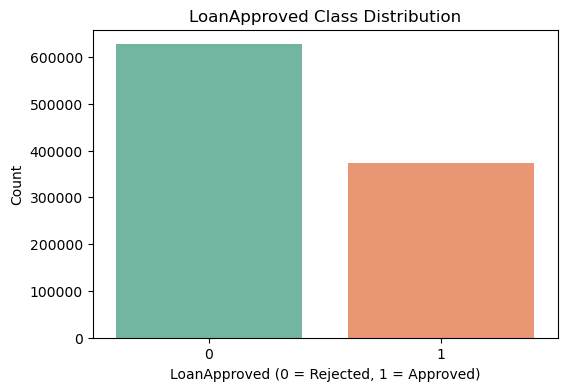

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.countplot(x="LoanApproved", data=df, palette="Set2")
plt.title("LoanApproved Class Distribution")
plt.xlabel("LoanApproved (0 = Rejected, 1 = Approved)")
plt.ylabel("Count")
plt.show()

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Separate features and target
X = df.drop("LoanApproved", axis=1)
y = df["LoanApproved"]

# Initialize undersampler
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Apply undersampling
X_res, y_res = rus.fit_resample(X, y)

# Check new class distribution
print("Original:", Counter(y))
print("Resampled:", Counter(y_res))


Original: Counter({0: 626831, 1: 373169})
Resampled: Counter({0: 373169, 1: 373169})


In [ ]:
# Get unique values and their counts in the resampled target variable (y_res)
unique_y_res_counts = y_res.value_counts()
print("Unique values and counts in y_res:\n", unique_y_res_counts)

# Get unique values and their counts for each feature in the resampled features (X_res)
unique_X_res_counts = {}
for column in X_res.columns:
    unique_X_res_counts[column] = X_res[column].value_counts()

# Check unique values and counts in each column of X_res
for column, value_counts in unique_X_res_counts.items():
    print(f"Unique values and counts in {column}:\n {value_counts.head()}")  # Showing only the first 5 for brevity


Unique values and counts in y_res:
 0    373169
1    373169
Name: LoanApproved, dtype: int64
Unique values and counts in CreditScore:
 508    1621
577    1608
521    1607
678    1606
813    1597
Name: CreditScore, dtype: int64
Unique values and counts in AnnualIncome:
 60336    37
53002    37
56793    36
57654    36
64235    35
Name: AnnualIncome, dtype: int64
Unique values and counts in LoanAmount:
 19143    92
17908    87
20453    87
18540    86
19079    84
Name: LoanAmount, dtype: int64
Unique values and counts in LoanDuration:
 21    26208
18    26034
28    26016
29    25981
10    25945
Name: LoanDuration, dtype: int64
Unique values and counts in Age:
 38    14617
56    14615
64    14538
22    14532
60    14502
Name: Age, dtype: int64
Unique values and counts in EmploymentStatus:
 Unemployed       248990
Employed         248756
Self-Employed    248592
Name: EmploymentStatus, dtype: int64
Unique values and counts in MaritalStatus:
 Single      186972
Married     186790
Divorced    1

In [ ]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Step 1: Identify categorical columns (object dtype)
categorical_columns = X_res.select_dtypes(include=['object']).columns

# Step 2: Label encode all categorical columns
le = LabelEncoder()
for column in categorical_columns:
    X_res[column] = le.fit_transform(X_res[column])

# Now X_res is fully numerical:
# - Categorical columns are label encoded
# - Numerical columns are untouched
print("✅ Preprocessing complete. Here's a preview:")
print(X_res.head())


✅ Preprocessing complete. Here's a preview:
        CreditScore  AnnualIncome  LoanAmount  LoanDuration  Age  \
428899          356         56568       20026            25   22   
644855          306         75066       16417             6   51   
582815          409         85834       21067             9   49   
457302          811         53257       25283             8   39   
890644          758         36345       16264            10   61   

        EmploymentStatus  MaritalStatus  NumberOfDependents  EducationLevel  \
428899                 1              2                   3               2   
644855                 0              0                   0               3   
582815                 2              2                   3               1   
457302                 1              0                   3               4   
890644                 2              3                   0               3   

        HomeOwnershipStatus  ...  EmployerType  JobTenure  MonthlySaving

In [ ]:
from sklearn.model_selection import train_test_split

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Check the shape of the split data
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (597070, 50)
X_test shape: (149268, 50)
y_train shape: (597070,)
y_test shape: (149268,)


# FInd Algorithem = XGboot

In [ ]:
import time
import random
import math
import xgboost as xgb
from deap import base, creator, tools, algorithms
from pyswarm import pso
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as pl

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")

In [ ]:
# DEAP setup for GA
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

def evaluate_features(feature_mask, X_train, X_test, y_train, y_test):
    """Evaluates feature subset using XGBoost with GPU acceleration."""
    selected_indices = [i for i, val in enumerate(feature_mask) if val > 0.5]

    if not selected_indices or len(selected_indices) < 3:
        return float('inf')

    param = {
        'objective': 'reg:squarederror',
        'tree_method': 'hist',
        'device': 'cuda',
        'max_depth': 5,
        'eta': 0.1
    }

    dtrain = xgb.DMatrix(X_train.iloc[:, selected_indices], label=y_train)
    dtest = xgb.DMatrix(X_test.iloc[:, selected_indices], label=y_test)

    model = xgb.train(
        param, dtrain,
        num_boost_round=100,
        early_stopping_rounds=10,
        evals=[(dtrain, 'train'), (dtest, 'test')],
        verbose_eval=False
    )

    return mean_squared_error(y_test, model.predict(dtest))

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


## 2. CUSTOM WHALE OPTIMIZATION ALGORITHM

In [ ]:
class WOA:
    """Custom implementation of Whale Optimization Algorithm"""
    def __init__(self, func, dim, lb, ub, n_whales=30, max_iter=20):
        self.func = func
        self.dim = dim
        self.lb = lb
        self.ub = ub
        self.n_whales = n_whales
        self.max_iter = max_iter
        self.history = {'mse': [], 'time': []}

    def optimize(self):
        start_time = time.time()

        # Initialize whales
        whales = np.random.uniform(self.lb, self.ub, (self.n_whales, self.dim))
        fitness = np.array([self.func(w) for w in whales])
        best_idx = np.argmin(fitness)
        best_whale = whales[best_idx].copy()
        best_fitness = fitness[best_idx]

        # Optimization loop
        for t in range(self.max_iter):
            a = 2 - t * (2 / self.max_iter)  # a decreases linearly from 2 to 0
            a2 = -1 + t * (-1 / self.max_iter)  # a2 decreases linearly from -1 to -2

            for i in range(self.n_whales):
                r1, r2 = np.random.rand(), np.random.rand()
                A = 2 * a * r1 - a
                C = 2 * r2
                b = 1  # Spiral constant
                l = (a2 - 1) * np.random.rand() + 1
                p = np.random.rand()

                if p < 0.5:
                    if abs(A) < 1:
                        # Encircling prey
                        D = abs(C * best_whale - whales[i])
                        whales[i] = best_whale - A * D
                    else:
                        # Search for prey
                        rand_idx = np.random.randint(0, self.n_whales)
                        rand_whale = whales[rand_idx]
                        D = abs(C * rand_whale - whales[i])
                        whales[i] = rand_whale - A * D
                else:
                    # Bubble-net attacking
                    D = abs(best_whale - whales[i])
                    whales[i] = D * np.exp(b * l) * np.cos(2 * np.pi * l) + best_whale

                # Apply bounds
                whales[i] = np.clip(whales[i], self.lb, self.ub)

                # Evaluate new solution
                fitness[i] = self.func(whales[i])

                # Update best
                if fitness[i] < best_fitness:
                    best_whale = whales[i].copy()
                    best_fitness = fitness[i]

            self.history['mse'].append(best_fitness)
            self.history['time'].append(time.time() - start_time)

        return best_whale, best_fitness

## 3. SQUID GAME OPTIMIZER (SGO) IMPLEMENTATION

In [ ]:
class SquidGameOptimizer:
    """Enhanced SGO with offensive/defensive strategies and elimination rounds."""
    def __init__(self, func, dim, lb, ub, n_players=30, max_games=20):
        self.func = func
        self.dim = dim
        self.lb = lb
        self.ub = ub
        self.n_players = n_players
        self.max_games = max_games
        self.history = {'mse': [], 'time': []}

    def optimize(self):
        start_time = time.time()

        # Initialize players with roles (0=defensive, 1=offensive)
        players = np.random.uniform(self.lb, self.ub, (self.n_players, self.dim))
        roles = np.random.randint(0, 2, self.n_players)
        fitness = np.array([self.func(p) for p in players])
        best_idx = np.argmin(fitness)
        best_player = players[best_idx].copy()
        best_fitness = fitness[best_idx]

        for game in range(self.max_games):
            new_players = np.zeros_like(players)
            elimination_prob = 0.2 + (0.5 * game / self.max_games)  # Increasing elimination pressure

            for i in range(self.n_players):
                if roles[i] == 1:  # Offensive player
                    # Aggressive move toward best player with momentum
                    A = np.random.uniform(0.5, 1.5, self.dim)
                    new_players[i] = np.clip(best_player * A, self.lb, self.ub)
                else:  # Defensive player
                    # Local search with adaptive step size
                    step = np.random.normal(0, 0.5*(1-game/self.max_games), self.dim)
                    new_players[i] = np.clip(players[i] + step, self.lb, self.ub)

                # Role adaptation
                if random.random() < 0.1:  # 10% chance to switch roles
                    roles[i] = 1 - roles[i]

            # Evaluate and apply elimination
            for i in range(self.n_players):
                new_fitness = self.func(new_players[i])

                # Survival condition
                if (new_fitness < fitness[i] or
                    random.random() > elimination_prob or
                    (roles[i] == 1 and new_fitness < 1.1*best_fitness)):

                    players[i] = new_players[i]
                    fitness[i] = new_fitness

                    if new_fitness < best_fitness:
                        best_player = new_players[i].copy()
                        best_fitness = new_fitness

            self.history['mse'].append(best_fitness)
            self.history['time'].append(time.time() - start_time)

        return best_player, best_fitness

In [ ]:
class PSH_Hyptrite:
    """Fixed implementation with bounds checking"""
    def __init__(self, func, dim, lb, ub, n_points=30, max_iter=20):
        self.func = func
        self.dim = dim
        self.lb = np.array(lb)  # Convert to numpy array
        self.ub = np.array(ub)  # Convert to numpy array
        self.n_points = n_points
        self.max_iter = max_iter
        self.history = {'mse': [], 'time': []}

    def hypersphere_sampling(self, center, radius, n_samples):
        """Generates points on hypersphere surface with bounds checking"""
        points = np.random.normal(size=(n_samples, self.dim))
        points = points / np.linalg.norm(points, axis=1)[:, np.newaxis]
        new_points = center + radius * points
        return np.clip(new_points, self.lb, self.ub)

    def optimize(self):
        start_time = time.time()

        # Initialize within bounds
        points = np.random.uniform(self.lb, self.ub, (self.n_points, self.dim))
        fitness = np.array([self.func(p) for p in points])
        best_idx = np.argmin(fitness)
        best_point = points[best_idx].copy()
        best_fitness = fitness[best_idx]

        initial_radius = 0.5 * np.mean(self.ub - self.lb)  # Fixed radius calculation

        for iter in range(self.max_iter):
            radius = initial_radius * (1 - iter/self.max_iter)

            # Generate new points
            new_points = []
            for p in points:
                hs_points = self.hypersphere_sampling(p, radius, 3)
                new_points.extend(hs_points)

            # Evaluate and combine
            new_points = np.array(new_points)
            new_fitness = np.array([self.func(p) for p in new_points])

            all_points = np.vstack([points, new_points])
            all_fitness = np.concatenate([fitness, new_fitness])

            # Select best
            best_indices = np.argpartition(all_fitness, self.n_points)[:self.n_points]
            points = all_points[best_indices]
            fitness = all_fitness[best_indices]

            # Update best
            current_best = np.min(fitness)
            if current_best < best_fitness:
                best_fitness = current_best
                best_point = points[np.argmin(fitness)].copy()

            self.history['mse'].append(best_fitness)
            self.history['time'].append(time.time() - start_time)

            print(f"Iter {iter+1}/{self.max_iter} | Best MSE: {best_fitness:.6f}", end='\r')

        print(f"\nOptimization completed in {time.time()-start_time:.2f}s")
        return best_point, best_fitness

## ALGORITHM IMPLEMENTATIONS (ONE-BY-ONE)

In [ ]:
def run_genetic_algorithm(X_train, X_test, y_train, y_test, verbose=True):
    """Enhanced GA with detailed progress tracking and reporting"""
    print("\n" + "="*50)
    print("=== GENETIC ALGORITHM OPTIMIZATION ===")
    print("="*50 + "\n")

    start_time = time.time()

    # 1. Initialization
    if verbose:
        print("[Initialization]")
        print(f"- Population size: 30")
        print(f"- Generations: 20")
        print(f"- Crossover rate: 80%")
        print(f"- Mutation rate: 20%")
        print(f"- Search space: {X_train.shape[1]} features")
        print(f"- Target: Minimize MSE using XGBoost\n")

    # 2. Setup evolutionary toolbox
    toolbox = base.Toolbox()
    toolbox.register("attr_bool", random.random)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=X_train.shape[1])
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("evaluate", lambda ind: (evaluate_features(ind, X_train, X_test, y_train, y_test),))
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.2, indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=3)

    # 3. Initialize population
    population = toolbox.population(n=30)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values[0])
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    stats.register("time", lambda _: time.time() - start_time)

    # 4. Evolutionary loop with progress tracking
    logbook = tools.Logbook()
    print("[Evolution Progress]")
    for gen in range(20):
        # Evolve population
        offspring = algorithms.varAnd(population, toolbox, cxpb=0.8, mutpb=0.2)
        fits = toolbox.map(toolbox.evaluate, offspring)

        # Update fitness
        for fit, ind in zip(fits, offspring):
            ind.fitness.values = fit

        # Selection
        population = toolbox.select(offspring, k=len(population))
        hof.update(population)

        # Record stats
        record = stats.compile(population)
        logbook.record(gen=gen, **record)

        # Print progress every 5 generations
        if gen % 5 == 0 or gen == 19:
            print(f"Gen {gen+1:02d}/20 | Best MSE: {record['min']:.6f} | Avg MSE: {record['avg']:.6f}")

    # 5. Results extraction
    best_ind = hof[0]
    best_mask = [x > 0.5 for x in best_ind]
    selected_features = [X_train.columns[i] for i, val in enumerate(best_mask) if val]
    n_selected = len(selected_features)
    reduction = 100 * (1 - n_selected/X_train.shape[1])
    elapsed = time.time() - start_time

    # 6. Detailed reporting
    print("\n" + "="*50)
    print("=== OPTIMIZATION RESULTS ===")
    print("="*50)
    print(f"\n▶ Best MSE achieved: {best_ind.fitness.values[0]:.6f}")
    print(f"▶ Time elapsed: {elapsed:.2f} seconds")
    print(f"▶ Features selected: {n_selected}/{X_train.shape[1]} ({reduction:.1f}% reduction)")

    print("\n▶ Selected features:")
    for i, feat in enumerate(selected_features, 1):
        print(f"{i}. {feat}")

    # 7. Convergence analysis
    if logbook:
        print("\n▶ Convergence progress:")
        print(f"- Initial MSE: {logbook[0]['min']:.4f}")
        print(f"- Final MSE: {logbook[-1]['min']:.4f}")
        improvement = 100*(logbook[0]['min']-logbook[-1]['min'])/logbook[0]['min']
        print(f"- Improvement: {improvement:.1f}%")

        plt.figure(figsize=(10,5))
        plt.plot(logbook.select('gen'), logbook.select('min'), 'b-o', label='Best')
        plt.plot(logbook.select('gen'), logbook.select('avg'), 'r--', label='Average')
        plt.title('GA Convergence')
        plt.xlabel('Generation')
        plt.ylabel('MSE')
        plt.legend()
        plt.grid(True)
        plt.show()

    return {
        'mse': best_ind.fitness.values[0],
        'features': selected_features,
        'time': elapsed,
        'history': logbook
    }

In [ ]:
def run_pso_algorithm(X_train, X_test, y_train, y_test, verbose=True):
    """Complete Particle Swarm Optimization implementation for feature selection"""
    print("\n" + "="*50)
    print("=== PARTICLE SWARM OPTIMIZATION ===")
    print("="*50 + "\n")

    start_time = time.time()
    n_features = X_train.shape[1]

    # 1. Initialization
    if verbose:
        print("[Initialization]")
        print(f"- Swarm size: 30 particles")
        print(f"- Iterations: 20")
        print(f"- Cognitive weight: 0.5")
        print(f"- Social weight: 0.5")
        print(f"- Inertia weight: 0.5")
        print(f"- Search space: {n_features} features")
        print(f"- Target: Minimize MSE using XGBoost\n")

    # 2. Setup bounds and history tracking
    lb = [0] * n_features
    ub = [1] * n_features
    history = {'mse': [], 'time': [], 'features': [], 'iterations': []}
    iteration = [0]  # Using list to allow modification in nested function

    # 3. Enhanced objective function with progress tracking
    def objective(feature_mask):
        mse = evaluate_features(feature_mask, X_train, X_test, y_train, y_test)

        # Track all evaluations
        history['mse'].append(mse)
        history['time'].append(time.time() - start_time)
        history['features'].append(np.sum(feature_mask > 0.5))

        # Only count complete iterations (swarmsize evaluations = 1 iteration)
        if len(history['mse']) % 30 == 0:
            iteration[0] += 1
            history['iterations'].append({
                'iteration': iteration[0],
                'mse': mse,
                'time': time.time() - start_time
            })
            if verbose and (iteration[0] % 5 == 0 or iteration[0] == 1):
                print(f"Iteration {iteration[0]}: Best MSE = {mse:.6f}")

        return mse

    # 4. Run PSO with corrected parameters
    print("[Optimization Progress]")
    best_mask, best_mse = pso(
        objective,
        lb, ub,
        swarmsize=30,
        maxiter=20,
        phip=0.5,  # cognitive parameter
        phig=0.5,  # social parameter
        omega=0.5,  # inertia
        minstep=1e-4,
        minfunc=1e-4,
        debug=True  # Use pyswarm's built-in progress
    )

    # 5. Post-process results
    best_mask = np.array(best_mask)
    selected_indices = np.where(best_mask > 0.5)[0]

    # Ensure minimum 3 features are selected
    if len(selected_indices) < 3:
        selected_indices = np.argsort(best_mask)[-3:]
        best_mask = np.zeros_like(best_mask)
        best_mask[selected_indices] = 1
        best_mse = objective(best_mask)  # Re-evaluate

    selected_features = [X_train.columns[i] for i in selected_indices]
    n_selected = len(selected_features)
    reduction = 100 * (1 - n_selected/n_features)
    elapsed = time.time() - start_time

    # 6. Results reporting
    print("\n" + "="*50)
    print("=== OPTIMIZATION RESULTS ===")
    print("="*50)
    print(f"\n▶ Best MSE achieved: {best_mse:.6f}")
    print(f"▶ Time elapsed: {elapsed:.2f} seconds")
    print(f"▶ Features selected: {n_selected}/{n_features} ({reduction:.1f}% reduction)")

    print("\n▶ Selected features (with weights):")
    for i, feat in enumerate(selected_features, 1):
        print(f"{i}. {feat} (weight: {best_mask[selected_indices[i-1]]:.3f})")

    # 7. Enhanced convergence visualization
    if history['iterations']:
        plt.figure(figsize=(12, 5))

        # MSE vs Iterations
        plt.subplot(1, 2, 1)
        iterations = [x['iteration'] for x in history['iterations']]
        mses = [x['mse'] for x in history['iterations']]
        plt.plot(iterations, mses, 'b-o', linewidth=2)
        plt.title('PSO Convergence')
        plt.xlabel('Iteration')
        plt.ylabel('MSE')
        plt.grid(True)

        # Time vs MSE
        plt.subplot(1, 2, 2)
        times = [x['time'] for x in history['iterations']]
        plt.plot(times, mses, 'r-', linewidth=2)
        plt.title('Optimization Progress')
        plt.xlabel('Time (s)')
        plt.ylabel('MSE')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    return {
        'mse': best_mse,
        'features': selected_features,
        'feature_weights': best_mask,
        'time': elapsed,
        'history': history
    }

In [ ]:
def run_woa_algorithm(X_train, X_test, y_train, y_test, verbose=True):
    """Enhanced WOA with detailed progress tracking and reporting"""
    print("\n" + "="*50)
    print("=== WHALE OPTIMIZATION ALGORITHM ===")
    print("="*50 + "\n")

    start_time = time.time()
    n_features = X_train.shape[1]

    # 1. Initialization
    if verbose:
        print("[Initialization]")
        print(f"- Population: 30 whales")
        print(f"- Max iterations: 20")
        print(f"- Spiral coefficient (b): 1.0")
        print(f"- Search space: {n_features} features")
        print(f"- Target: Minimize MSE using XGBoost\n")

    # 2. Setup bounds and history tracking
    lb = [0] * n_features
    ub = [1] * n_features
    history = {'mse': [], 'time': [], 'features': []}

    # 3. Objective function with tracking
    def objective(feature_mask):
        mse = evaluate_features(feature_mask, X_train, X_test, y_train, y_test)
        history['mse'].append(mse)
        history['time'].append(time.time() - start_time)
        history['features'].append(np.sum(feature_mask > 0.5))
        return mse

    # 4. WOA Implementation
    class EnhancedWOA:
        def __init__(self, func, dim, lb, ub, n_whales=30, max_iter=20):
            self.func = func
            self.dim = dim
            self.lb = np.array(lb)
            self.ub = np.array(ub)
            self.n_whales = n_whales
            self.max_iter = max_iter
            self.b = 1.0  # Spiral coefficient

        def optimize(self):
            # Initialize whales
            whales = np.random.uniform(self.lb, self.ub, (self.n_whales, self.dim))
            fitness = np.array([self.func(w) for w in whales])
            best_idx = np.argmin(fitness)
            best_whale = whales[best_idx].copy()
            best_fitness = fitness[best_idx]

            print("[Optimization Progress]")
            for iter in range(self.max_iter):
                a = 2 - iter * (2 / self.max_iter)  # a decreases linearly 2→0
                a2 = -1 + iter * (-1 / self.max_iter)  # a2 decreases linearly -1→-2

                for i in range(self.n_whales):
                    r1, r2 = np.random.rand(), np.random.rand()
                    A = 2 * a * r1 - a
                    C = 2 * r2
                    l = (a2 - 1) * np.random.rand() + 1
                    p = np.random.rand()

                    if p < 0.5:
                        if abs(A) < 1:
                            # Encircling prey
                            D = abs(C * best_whale - whales[i])
                            whales[i] = best_whale - A * D
                        else:
                            # Search for prey
                            rand_idx = np.random.randint(0, self.n_whales)
                            rand_whale = whales[rand_idx]
                            D = abs(C * rand_whale - whales[i])
                            whales[i] = rand_whale - A * D
                    else:
                        # Bubble-net attacking
                        D = abs(best_whale - whales[i])
                        whales[i] = D * np.exp(self.b * l) * np.cos(2 * np.pi * l) + best_whale

                    # Boundary check
                    whales[i] = np.clip(whales[i], self.lb, self.ub)

                    # Evaluate new solution
                    fitness[i] = self.func(whales[i])

                    # Update best
                    if fitness[i] < best_fitness:
                        best_whale = whales[i].copy()
                        best_fitness = fitness[i]

                # Print progress every 5 iterations
                if iter % 5 == 0 or iter == self.max_iter - 1:
                    print(f"Iter {iter+1:02d}/{self.max_iter} | Best MSE: {best_fitness:.6f}",
                          end='\r' if iter != self.max_iter - 1 else '\n')

            return best_whale, best_fitness

    # 5. Run optimization
    optimizer = EnhancedWOA(
        func=objective,
        dim=n_features,
        lb=lb,
        ub=ub,
        n_whales=30,
        max_iter=20
    )
    best_mask, best_mse = optimizer.optimize()

    # 6. Results extraction
    selected_features = [X_train.columns[i] for i, val in enumerate(best_mask) if val > 0.5]
    n_selected = len(selected_features)
    reduction = 100 * (1 - n_selected/n_features)
    elapsed = time.time() - start_time

    # 7. Detailed reporting
    print("\n" + "="*50)
    print("=== OPTIMIZATION RESULTS ===")
    print("="*50)
    print(f"\n▶ Best MSE achieved: {best_mse:.6f}")
    print(f"▶ Time elapsed: {elapsed:.2f} seconds")
    print(f"▶ Features selected: {n_selected}/{n_features} ({reduction:.1f}% reduction)")

    print("\n▶ Selected features:")
    for i, feat in enumerate(selected_features, 1):
        print(f"{i}. {feat}")

    # 8. Convergence analysis
    if history['mse']:
        print("\n▶ Convergence progress:")
        print(f"- Initial MSE: {history['mse'][0]:.4f}")
        print(f"- Final MSE: {history['mse'][-1]:.4f}")
        improvement = 100*(history['mse'][0]-history['mse'][-1])/history['mse'][0]
        print(f"- Improvement: {improvement:.1f}%")

        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        plt.plot(history['mse'], 'b-o', linewidth=2)
        plt.title('WOA Convergence')
        plt.xlabel('Iteration')
        plt.ylabel('MSE')
        plt.grid(True)

        plt.subplot(1,2,2)
        plt.plot(history['time'], history['mse'], 'r-', linewidth=2)
        plt.title('Time vs Performance')
        plt.xlabel('Time (s)')
        plt.ylabel('MSE')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    return {
        'mse': best_mse,
        'features': selected_features,
        'time': elapsed,
        'history': history
    }


In [ ]:
def run_sgo(X_train, X_test, y_train, y_test, verbose=True):
    """Runs Squid Game Optimizer with detailed printing"""
    print("\n" + "="*50)
    print("=== SQUID GAME OPTIMIZER (SGO) ===")
    print("="*50 + "\n")

    start_time = time.time()

    # 1. Initialization
    if verbose:
        print("[Initialization]")
        print(f"- Players: 30 (15 offensive, 15 defensive)")
        print(f"- Max games: 20")
        print(f"- Search space: {X_train.shape[1]} features")
        print(f"- Target: Minimize MSE using XGBoost\n")

    # 2. Optimization
    def objective(feature_mask):
        return evaluate_features(feature_mask, X_train, X_test, y_train, y_test)

    optimizer = SquidGameOptimizer(
        func=objective,
        dim=X_train.shape[1],
        lb=0, ub=1,
        n_players=30,
        max_games=20
    )

    best_mask, best_mse = optimizer.optimize()
    elapsed = time.time() - start_time

    # 3. Results
    selected_features = [X_train.columns[i] for i, val in enumerate(best_mask) if val > 0.5]
    n_selected = len(selected_features)
    reduction = 100 * (1 - n_selected/X_train.shape[1])

    print("\n" + "="*50)
    print("=== OPTIMIZATION RESULTS ===")
    print("="*50)
    print(f"\n▶ Best MSE achieved: {best_mse:.6f}")
    print(f"▶ Time elapsed: {elapsed:.2f} seconds")
    print(f"▶ Features selected: {n_selected}/{X_train.shape[1]} ({reduction:.1f}% reduction)")

    print("\n▶ Selected features:")
    for i, feat in enumerate(selected_features, 1):
        print(f"{i}. {feat}")

    # 4. Convergence Analysis
    if optimizer.history['mse']:
        print("\n▶ Convergence progress:")
        print(f"- Initial MSE: {optimizer.history['mse'][0]:.4f}")
        print(f"- Final MSE: {optimizer.history['mse'][-1]:.4f}")
        improvement = 100*(optimizer.history['mse'][0]-optimizer.history['mse'][-1])/optimizer.history['mse'][0]
        print(f"- Improvement: {improvement:.1f}%")

        plt.figure(figsize=(10,5))
        plt.plot(optimizer.history['mse'], 'b-o', linewidth=2)
        plt.title('SGO Convergence')
        plt.xlabel('Game Round')
        plt.ylabel('MSE')
        plt.grid(True)
        plt.show()

    return {
        'mse': best_mse,
        'features': selected_features,
        'time': elapsed,
        'history': optimizer.history
    }

In [ ]:
def run_psh_hyptrite(X_train, X_test, y_train, y_test, verbose=True):
    """Complete PSH-Hyptrite optimization for feature selection"""
    print("\n" + "="*50)
    print("=== PSH-HYPTRITE OPTIMIZATION ===")
    print("="*50 + "\n")

    start_time = time.time()
    n_features = X_train.shape[1]

    # 1. Initialization
    if verbose:
        print("[Initialization]")
        print(f"- Search points: 30")
        print(f"- Max iterations: 20")
        print(f"- Initial radius: 0.5 (adaptive)")
        print(f"- Hypersphere samples: 3 per point")
        print(f"- Search space: {n_features} features")
        print(f"- Target: Minimize MSE using XGBoost\n")

    # 2. Setup bounds and history tracking
    lb = [0] * n_features
    ub = [1] * n_features
    history = {'mse': [], 'time': [], 'features': []}

    # 3. Objective function with tracking
    def objective(feature_mask):
        mse = evaluate_features(feature_mask, X_train, X_test, y_train, y_test)
        history['mse'].append(mse)
        history['time'].append(time.time() - start_time)
        history['features'].append(np.sum(feature_mask > 0.5))
        return mse

    # 4. PSH-Hyptrite Implementation
    class EnhancedPSH:
        def __init__(self, func, dim, lb, ub, n_points=30, max_iter=20):
            self.func = func
            self.dim = dim
            self.lb = np.array(lb)
            self.ub = np.array(ub)
            self.n_points = n_points
            self.max_iter = max_iter
            self.hs_samples = 3  # Hypersphere sampling points

        def hypersphere_sampling(self, center, radius, n_samples):
            """Generates points on hypersphere surface with bounds checking"""
            points = np.random.normal(size=(n_samples, self.dim))
            norms = np.linalg.norm(points, axis=1)[:, np.newaxis]
            points = points / np.where(norms == 0, 1, norms)  # Avoid division by zero
            new_points = center + radius * points
            return np.clip(new_points, self.lb, self.ub)

        def optimize(self):
            # Initialize search points
            points = np.random.uniform(self.lb, self.ub, (self.n_points, self.dim))
            fitness = np.array([self.func(p) for p in points])
            best_idx = np.argmin(fitness)
            best_point = points[best_idx].copy()
            best_fitness = fitness[best_idx]

            initial_radius = 0.5 * np.mean(self.ub - self.lb)

            print("[Optimization Progress]")
            for iter in range(self.max_iter):
                # Current adaptive radius
                radius = initial_radius * (1 - iter/self.max_iter)

                # Generate new points via hypersphere sampling
                new_points = []
                for p in points:
                    hs_points = self.hypersphere_sampling(p, radius, self.hs_samples)
                    new_points.extend(hs_points)
                new_points = np.array(new_points)

                # Evaluate new points
                new_fitness = np.array([self.func(p) for p in new_points])

                # Combine with previous points
                all_points = np.vstack([points, new_points])
                all_fitness = np.concatenate([fitness, new_fitness])

                # Select best n_points for next iteration
                best_indices = np.argpartition(all_fitness, self.n_points)[:self.n_points]
                points = all_points[best_indices]
                fitness = all_fitness[best_indices]

                # Update global best
                current_best = np.min(fitness)
                if current_best < best_fitness:
                    best_fitness = current_best
                    best_point = points[np.argmin(fitness)].copy()

                # Print progress every 5 iterations
                if iter % 5 == 0 or iter == self.max_iter - 1:
                    print(f"Iter {iter+1:02d}/{self.max_iter} | Best MSE: {best_fitness:.6f} | Radius: {radius:.4f}",
                          end='\r' if iter != self.max_iter - 1 else '\n')

            return best_point, best_fitness

    # 5. Run optimization
    optimizer = EnhancedPSH(
        func=objective,
        dim=n_features,
        lb=lb,
        ub=ub,
        n_points=30,
        max_iter=20
    )
    best_mask, best_mse = optimizer.optimize()

    # 6. Post-process results to ensure at least 3 features
    best_mask = np.array(best_mask)
    selected_indices = np.where(best_mask > 0.5)[0]

    if len(selected_indices) < 3:
        # Fallback to top 3 features by weight
        selected_indices = np.argsort(best_mask)[-3:]
        best_mask = np.zeros_like(best_mask)
        best_mask[selected_indices] = 1
        best_mse = objective(best_mask)  # Re-evaluate with enforced features

    selected_features = [X_train.columns[i] for i in selected_indices]
    n_selected = len(selected_features)
    reduction = 100 * (1 - n_selected/n_features)
    elapsed = time.time() - start_time

    # 7. Results reporting
    print("\n" + "="*50)
    print("=== OPTIMIZATION RESULTS ===")
    print("="*50)
    print(f"\n▶ Best MSE achieved: {best_mse:.6f}")
    print(f"▶ Time elapsed: {elapsed:.2f} seconds")
    print(f"▶ Features selected: {n_selected}/{n_features} ({reduction:.1f}% reduction)")

    print("\n▶ Selected features (with weights):")
    for i, feat in enumerate(selected_features, 1):
        print(f"{i}. {feat} (weight: {best_mask[selected_indices[i-1]]:.3f})")

    # 8. Convergence visualization
    if history['mse']:
        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        plt.plot(history['mse'], 'b-o', linewidth=2)
        plt.title('PSH-Hyptrite Convergence')
        plt.xlabel('Iteration')
        plt.ylabel('MSE')
        plt.grid(True)

        plt.subplot(1,2,2)
        plt.plot(history['time'], history['mse'], 'r-', linewidth=2)
        plt.title('Time vs Performance')
        plt.xlabel('Time (s)')
        plt.ylabel('MSE')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    return {
        'mse': best_mse,
        'features': selected_features,
        'feature_weights': best_mask,
        'time': elapsed,
        'history': history
    }

In [ ]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from deap import base, creator, tools, algorithms
from pyswarm import pso

def select_best_algorithm(X_train, X_test, y_train, y_test):
    """
    Automatically runs and compares optimization algorithms for feature selection,
    then returns the best performing algorithm's results.
    """
    # Dictionary to store all results
    results = {}

    # List of available algorithms (with their display names and functions)
    algorithms_to_run = [
        ('Genetic Algorithm', run_genetic_algorithm),
        ('Particle Swarm Optimization', run_pso_algorithm),
        ('Whale Optimization', run_woa_algorithm),
        ('Squid Game Optimizer', run_sgo),
        ('PSH-Hyptrite', run_psh_hyptrite)
    ]

    # Run each algorithm and store results
    for name, algorithm in algorithms_to_run:
        print(f"\n{'='*50}")
        print(f"Running {name}...")
        print(f"{'='*50}")
        try:
            results[name] = algorithm(X_train, X_test, y_train, y_test)
            print(f"{name} completed successfully with MSE: {results[name]['mse']:.4f}")
        except Exception as e:
            print(f"Error running {name}: {str(e)}")
            results[name] = None

    # Filter out failed algorithms
    valid_results = {k: v for k, v in results.items() if v is not None}

    if not valid_results:
        raise RuntimeError("All algorithms failed to run successfully")

    # Find the best algorithm (lowest MSE)
    best_algo_name = min(valid_results.keys(), key=lambda x: valid_results[x]['mse'])
    best_result = valid_results[best_algo_name]

    # Generate comparison report
    generate_comparison_report(valid_results, best_algo_name)

    return {
        'best_algorithm': best_algo_name,
        'best_mse': best_result['mse'],
        'selected_features': best_result['features'],
        'execution_time': best_result['time'],
        'all_results': valid_results
    }

def generate_comparison_report(results, best_algo_name):
    """Generates visual comparison of all algorithms"""
    plt.figure(figsize=(15, 10))

    # 1. MSE Comparison
    plt.subplot(2, 2, 1)
    names = list(results.keys())
    mses = [results[name]['mse'] for name in names]
    colors = ['green' if name == best_algo_name else 'blue' for name in names]
    plt.bar(names, mses, color=colors)
    plt.title('Algorithm Performance Comparison')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.xticks(rotation=45)
    plt.grid(True, axis='y')

    # 2. Execution Time
    plt.subplot(2, 2, 2)
    times = [results[name]['time'] for name in names]
    plt.bar(names, times, color=colors)
    plt.title('Execution Time Comparison')
    plt.ylabel('Time (seconds)')
    plt.xticks(rotation=45)
    plt.grid(True, axis='y')

    # 3. Feature Selection Count
    plt.subplot(2, 2, 3)
    feature_counts = [len(results[name]['features']) for name in names]
    plt.bar(names, feature_counts, color=colors)
    plt.title('Number of Selected Features')
    plt.ylabel('Feature Count')
    plt.xticks(rotation=45)
    plt.grid(True, axis='y')

    # 4. Convergence Plot
    plt.subplot(2, 2, 4)
    for name, result in results.items():
        if 'history' in result and 'mse' in result['history']:
            plt.plot(result['history']['mse'],
                    label=f"{name} (final: {result['mse']:.4f})",
                    linewidth=2 if name == best_algo_name else 1)
    plt.title('Convergence Comparison')
    plt.xlabel('Iteration')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Print summary
    print("\n" + "="*50)
    print("FINAL RESULTS SUMMARY")
    print("="*50)
    print(f"\n🏆 Best Algorithm: {best_algo_name}")
    print(f"📉 Best MSE Achieved: {results[best_algo_name]['mse']:.6f}")
    print(f"⏱️ Execution Time: {results[best_algo_name]['time']:.2f} seconds")
    print(f"🔢 Features Selected: {len(results[best_algo_name]['features'])}")
    print("\nSelected Features:")
    for i, feat in enumerate(results[best_algo_name]['features'], 1):
        print(f"{i}. {feat}")

# Example usage:
# best_results = select_best_algorithm(X_train, X_test, y_train, y_test)


Running Genetic Algorithm...

=== GENETIC ALGORITHM OPTIMIZATION ===

[Initialization]
- Population size: 30
- Generations: 20
- Crossover rate: 80%
- Mutation rate: 20%
- Search space: 50 features
- Target: Minimize MSE using XGBoost

[Evolution Progress]
Gen 01/20 | Best MSE: 0.143343 | Avg MSE: 0.155480
Gen 06/20 | Best MSE: 0.143339 | Avg MSE: 0.143347
Gen 11/20 | Best MSE: 0.143321 | Avg MSE: 0.143330
Gen 16/20 | Best MSE: 0.143321 | Avg MSE: 0.143321
Gen 20/20 | Best MSE: 0.143321 | Avg MSE: 0.143321

=== OPTIMIZATION RESULTS ===

▶ Best MSE achieved: 0.143321
▶ Time elapsed: 380.72 seconds
▶ Features selected: 25/50 (50.0% reduction)

▶ Selected features:
1. CreditScore
2. AnnualIncome
3. LoanDuration
4. EmploymentStatus
5. NumberOfDependents
6. HomeOwnershipStatus
7. CreditCardUtilizationRate
8. BankruptcyHistory
9. LoanPurpose
10. PreviousLoanDefaults
11. PaymentHistory
12. SavingsAccountBalance
13. CheckingAccountBalance
14. EmergencyFundBalance
15. RentPayments
16. AutoLoan

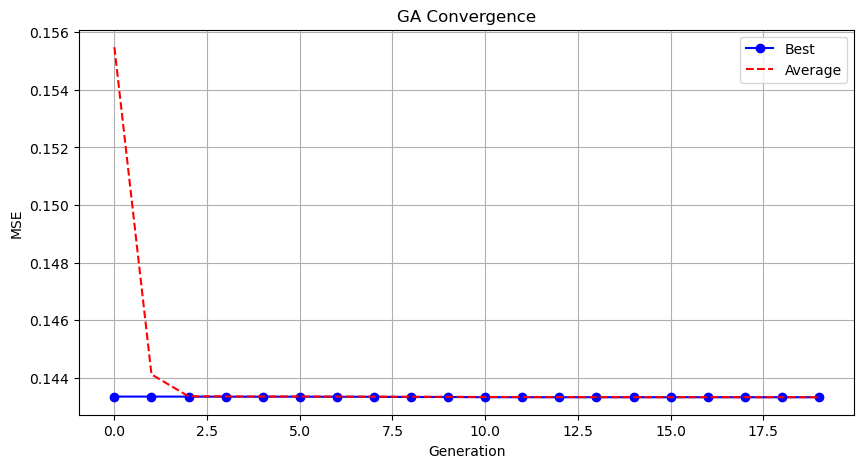

Genetic Algorithm completed successfully with MSE: 0.1433

Running Particle Swarm Optimization...

=== PARTICLE SWARM OPTIMIZATION ===

[Initialization]
- Swarm size: 30 particles
- Iterations: 20
- Cognitive weight: 0.5
- Social weight: 0.5
- Inertia weight: 0.5
- Search space: 50 features
- Target: Minimize MSE using XGBoost

[Optimization Progress]
No constraints given.
Iteration 1: Best MSE = 0.250035
New best for swarm at iteration 1: [1.         0.75713748 0.43626498 0.31055393 0.58387575 1.
 0.68334496 0.36219105 0.80538425 0.3040177  0.40368462 0.15450601
 0.83584203 1.         1.         0.63556193 1.         0.26944729
 0.85413439 0.0028078  0.85781403 0.50377655 1.         1.
 0.30503698 0.63416491 0.00545711 0.29862163 0.         0.
 0.72848018 0.         0.         0.74484857 0.         0.27256949
 1.         0.22175617 0.52599525 1.         0.         0.55475903
 0.22844933 0.53646159 0.38144573 0.         0.61371538 0.13680073
 0.63970083 1.        ] 0.14334197342395782


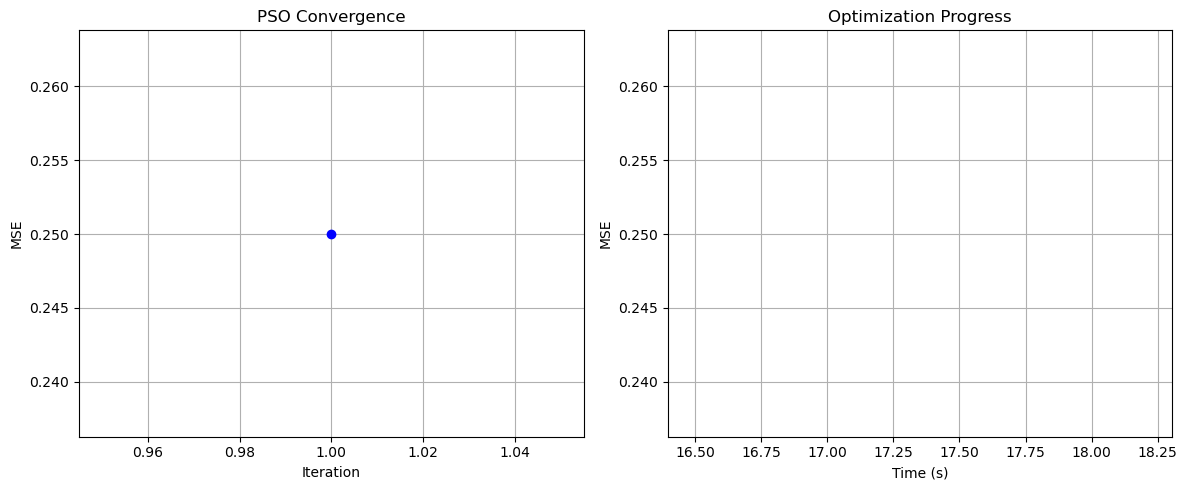

Particle Swarm Optimization completed successfully with MSE: 0.1433

Running Whale Optimization...

=== WHALE OPTIMIZATION ALGORITHM ===

[Initialization]
- Population: 30 whales
- Max iterations: 20
- Spiral coefficient (b): 1.0
- Search space: 50 features
- Target: Minimize MSE using XGBoost

[Optimization Progress]
Iter 20/20 | Best MSE: 0.143336

=== OPTIMIZATION RESULTS ===

▶ Best MSE achieved: 0.143336
▶ Time elapsed: 347.77 seconds
▶ Features selected: 20/50 (60.0% reduction)

▶ Selected features:
1. CreditScore
2. AnnualIncome
3. MaritalStatus
4. HomeOwnershipStatus
5. NumberOfOpenCreditLines
6. NumberOfCreditInquiries
7. LoanPurpose
8. PreviousLoanDefaults
9. PaymentHistory
10. SavingsAccountBalance
11. EmergencyFundBalance
12. TotalLiabilities
13. MortgageBalance
14. PersonalLoanBalance
15. CarInsuranceStatus
16. EmployerType
17. JobTenure
18. MonthlySavings
19. AnnualBonuses
20. MonthlyFoodCosts

▶ Convergence progress:
- Initial MSE: 0.1491
- Final MSE: 0.1433
- Improvemen

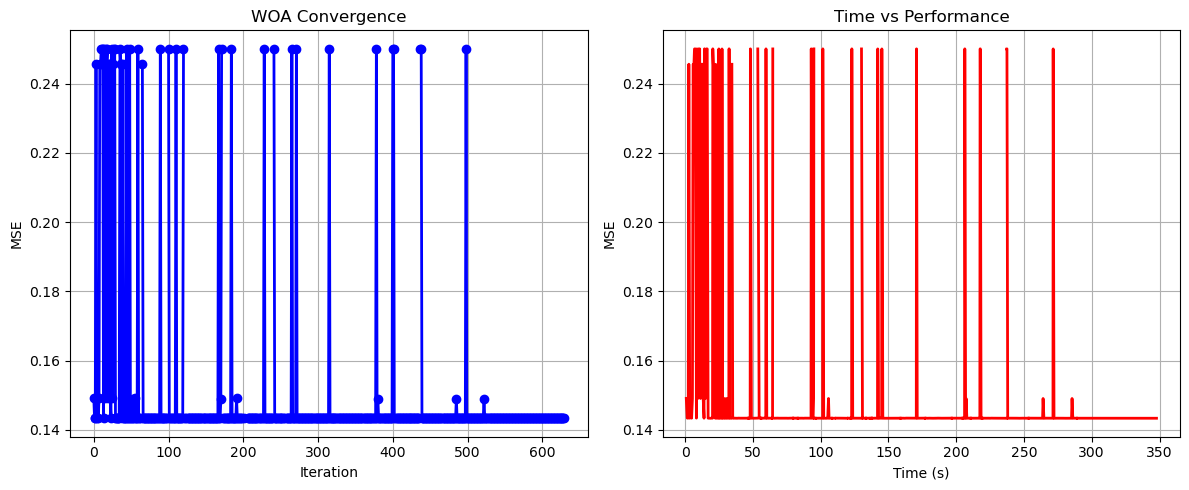

Whale Optimization completed successfully with MSE: 0.1433

Running Squid Game Optimizer...

=== SQUID GAME OPTIMIZER (SGO) ===

[Initialization]
- Players: 30 (15 offensive, 15 defensive)
- Max games: 20
- Search space: 50 features
- Target: Minimize MSE using XGBoost


=== OPTIMIZATION RESULTS ===

▶ Best MSE achieved: 0.143320
▶ Time elapsed: 359.33 seconds
▶ Features selected: 19/50 (62.0% reduction)

▶ Selected features:
1. CreditScore
2. AnnualIncome
3. LoanDuration
4. Age
5. HomeOwnershipStatus
6. NumberOfOpenCreditLines
7. DebtToIncomeRatio
8. BankruptcyHistory
9. LoanPurpose
10. InterestRate
11. CheckingAccountBalance
12. RetirementAccountBalance
13. StudentLoanBalance
14. HealthInsuranceStatus
15. CarInsuranceStatus
16. OtherInsurancePolicies
17. MonthlyHousingCosts
18. MonthlyFoodCosts
19. MonthlyHealthcareCosts

▶ Convergence progress:
- Initial MSE: 0.1433
- Final MSE: 0.1433
- Improvement: 0.0%


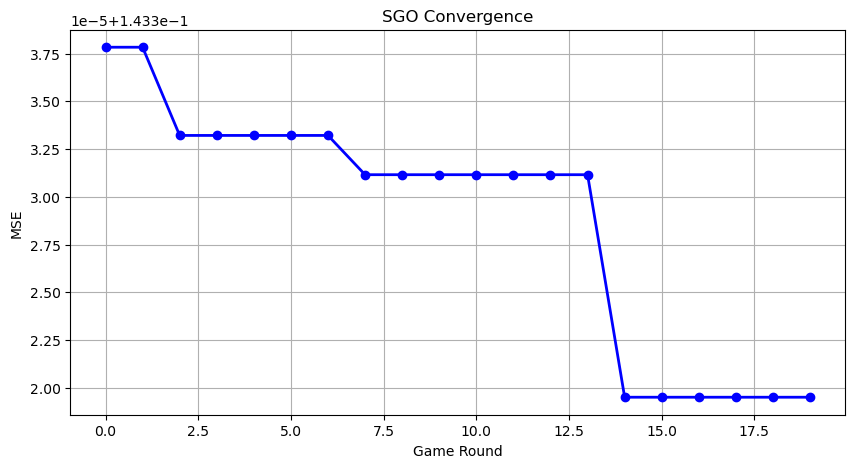

Squid Game Optimizer completed successfully with MSE: 0.1433

Running PSH-Hyptrite...

=== PSH-HYPTRITE OPTIMIZATION ===

[Initialization]
- Search points: 30
- Max iterations: 20
- Initial radius: 0.5 (adaptive)
- Hypersphere samples: 3 per point
- Search space: 50 features
- Target: Minimize MSE using XGBoost

[Optimization Progress]
Iter 20/20 | Best MSE: 0.143329 | Radius: 0.0250

=== OPTIMIZATION RESULTS ===

▶ Best MSE achieved: 0.143329
▶ Time elapsed: 1222.86 seconds
▶ Features selected: 26/50 (48.0% reduction)

▶ Selected features (with weights):
1. CreditScore (weight: 0.509)
2. AnnualIncome (weight: 0.732)
3. Age (weight: 1.000)
4. EmploymentStatus (weight: 0.885)
5. EducationLevel (weight: 0.512)
6. HomeOwnershipStatus (weight: 0.802)
7. MonthlyDebtPayments (weight: 0.532)
8. BankruptcyHistory (weight: 0.611)
9. PreviousLoanDefaults (weight: 0.805)
10. InterestRate (weight: 0.575)
11. PaymentHistory (weight: 0.803)
12. CheckingAccountBalance (weight: 0.535)
13. RetirementAc

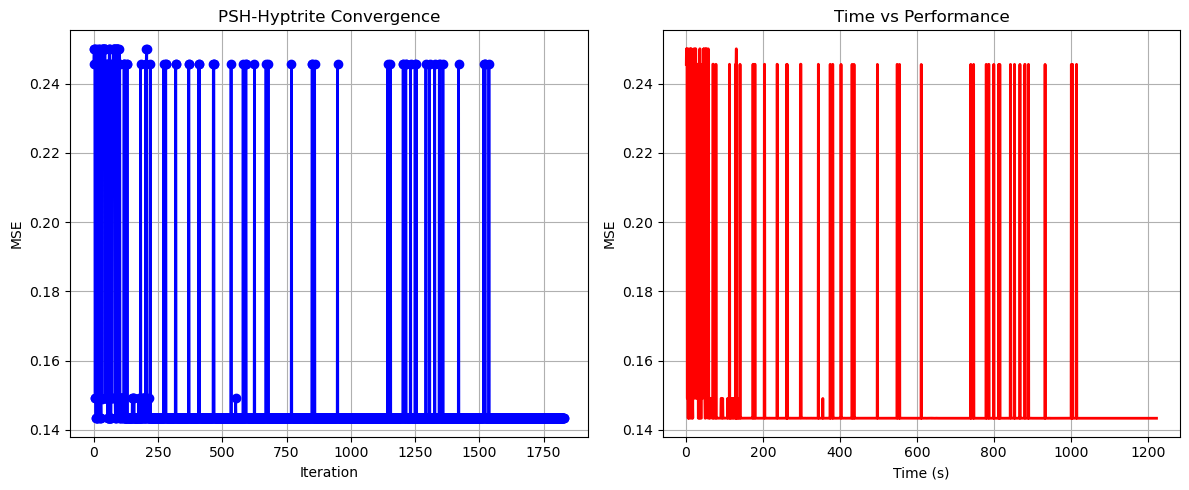

PSH-Hyptrite completed successfully with MSE: 0.1433


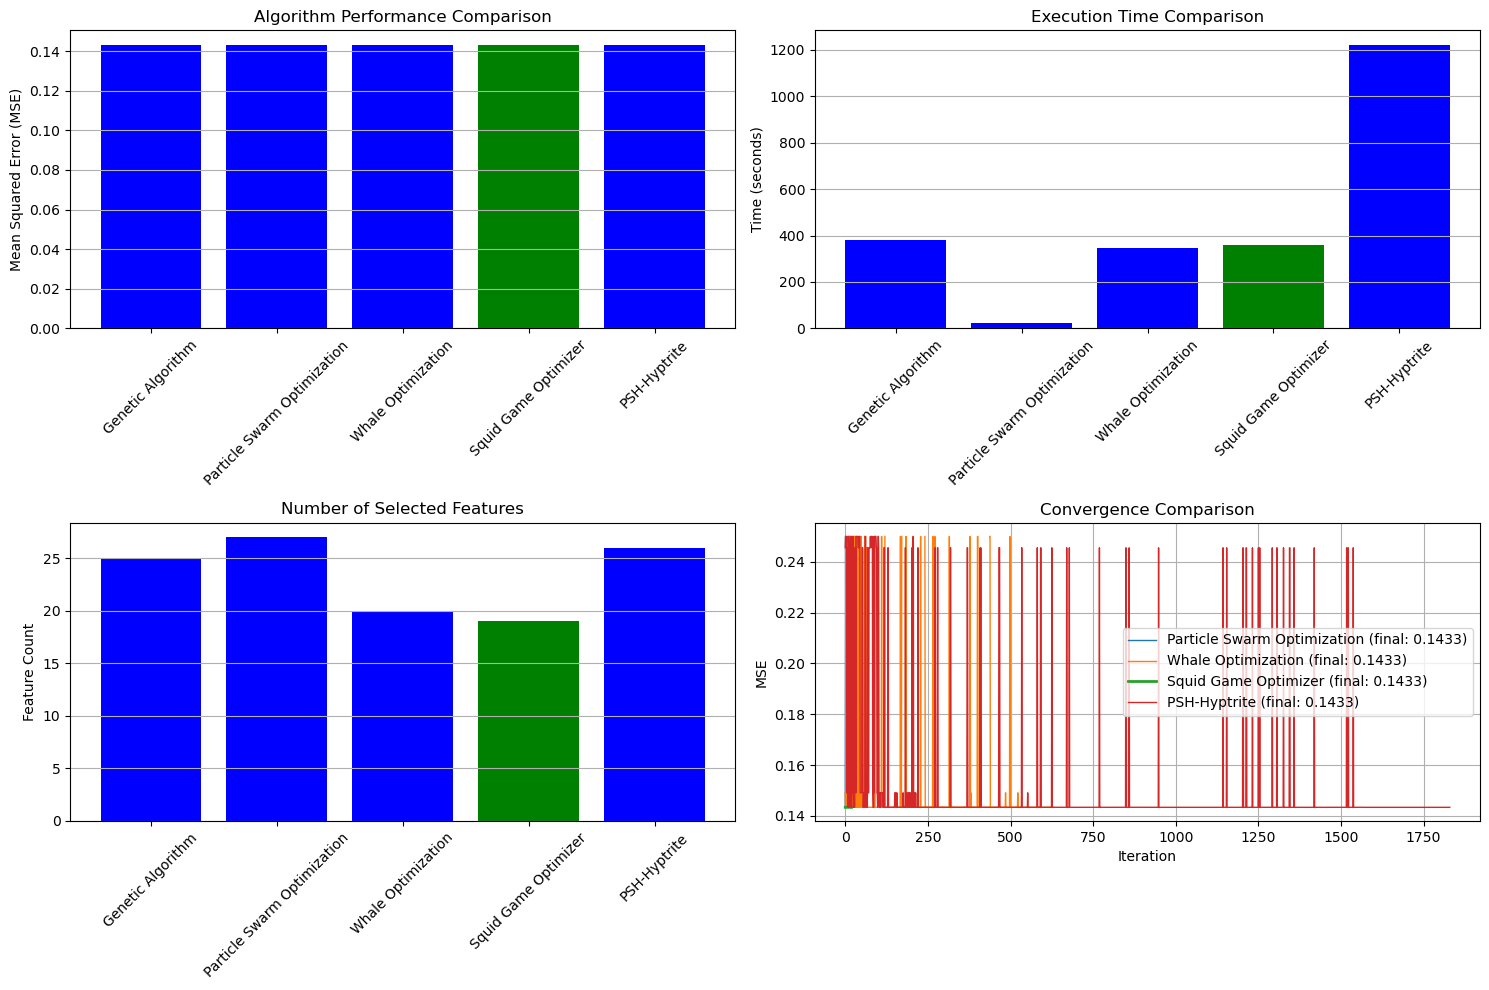


FINAL RESULTS SUMMARY

🏆 Best Algorithm: Squid Game Optimizer
📉 Best MSE Achieved: 0.143320
⏱️ Execution Time: 359.33 seconds
🔢 Features Selected: 19

Selected Features:
1. CreditScore
2. AnnualIncome
3. LoanDuration
4. Age
5. HomeOwnershipStatus
6. NumberOfOpenCreditLines
7. DebtToIncomeRatio
8. BankruptcyHistory
9. LoanPurpose
10. InterestRate
11. CheckingAccountBalance
12. RetirementAccountBalance
13. StudentLoanBalance
14. HealthInsuranceStatus
15. CarInsuranceStatus
16. OtherInsurancePolicies
17. MonthlyHousingCosts
18. MonthlyFoodCosts
19. MonthlyHealthcareCosts


In [ ]:
best_results = select_best_algorithm(X_train, X_test, y_train, y_test)